In [1]:
import matplotlib.pyplot as plt
import numpy as np
from warnings import filterwarnings
import torch
import torchkbnufft as tkbn
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

In [3]:
def create_image(echo_time,fov_x,fov_y,fov_z,t1_myelin, t1_wm, t2_myelin, t2_wm, t2_star_myelin, t2_star_wm, inv_time):
    #res in cm
    res = 0.1
    
    pixels_x = int(fov_x/res)
    pixels_y = int(fov_y/res)
    pixels_z = int(fov_z/res)

    mxy_myelin = (1-2*np.exp(-(inv_time/t1_myelin)))*np.exp(-(echo_time/t2_star_myelin))
    mxy_wm = (1-2*np.exp(-(inv_time/t1_wm)))*np.exp(-(echo_time/t2_star_wm))
    mxy_mixed = 0.5*((1-2*np.exp(-(inv_time/t1_wm)))*np.exp(-(echo_time/t2_star_wm))) + 0.5*((1-2*np.exp(-(inv_time/t1_myelin)))*np.exp(-(echo_time/t2_star_myelin)))
    
    # Initialize 3D image
    image_3d = np.ones((pixels_x, pixels_y, pixels_z))
    
    # Define cube sizes
    outer_cube_size = int(1.0 * pixels_x)
    middle_cube_size = int(0.6 * pixels_x)
    inner_cube_size = int(0.25 * pixels_x)
    
    # Calculate starting and ending indices for each cube
    def get_cube_bounds(size, pixels):
        start = (pixels - size) // 2
        end = start + size
        return start, end
    
    outer_start, outer_end = get_cube_bounds(outer_cube_size, pixels_x)
    middle_start, middle_end = get_cube_bounds(middle_cube_size, pixels_x)
    inner_start, inner_end = get_cube_bounds(inner_cube_size, pixels_x)
    
    # Assign intensity values
    image_3d[outer_start:outer_end, outer_start:outer_end, outer_start:outer_end] = mxy_wm  # Outer cube
    image_3d[middle_start:middle_end, middle_start:middle_end, middle_start:middle_end] = mxy_mixed  # Middle cube
    image_3d[inner_start:inner_end, inner_start:inner_end, inner_start:inner_end] = mxy_myelin  # Inner cube
    
    # # Visualization
    # fig = plt.figure(figsize=(8, 8))
    # ax = fig.add_subplot(111, projection='3d')
    
    # # Normalize the intensities for colormap
    # norm = colors.Normalize(vmin=np.min(image_3d), vmax=np.max(image_3d))
    
    # # Use a colormap, for example, 'viridis'
    # colormap = cm.viridis
    
    # # Map the intensities to colors using the colormap
    # colors_3d = colormap(norm(image_3d))
    
    # # Display the entire 3D voxel grid with transparency and colormap
    # # Use alpha for transparency
    # voxels = ax.voxels(image_3d > 0, facecolors=colors_3d, edgecolors='black', alpha=0.3)  # Adjust alpha for transparency
    
    # # Add a colorbar to the plot
    # cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=colormap), ax=ax, shrink=0.6)
    # cbar.set_label('Intensity')
    
    # ax.set_xlabel('X')
    # ax.set_ylabel('Y')
    # ax.set_zlabel('Z')
    # plt.title("3D Visualization of Nested Cubes with Transparency")
    
    # plt.show()

    # Compute the 3D FFT
    fft_3d = np.fft.fftn(image_3d)
    
    # Shift the FFT to center the zero frequency
    fft_3d_shifted = np.fft.fftshift(fft_3d)
    
    # Compute the magnitude of the FFT
    magnitude = np.abs(fft_3d_shifted)

    # Visualization of the 3D FFT magnitude using a 2D slice view
    # We will show a middle slice in the Z-axis for the magnitude
    slice_index_z = pixels_z // 2
    fft_slice = magnitude[:, :, slice_index_z]
    
    # Here we will take a slice along the XY-plane (Z-axis) and plot it
    X, Y = np.meshgrid(np.arange(pixels_x), np.arange(pixels_y))
    Z = fft_slice  # Magnitude at the slice we selected
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_title("3D FFT Magnitude Surface Plot (XY-plane slice)")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Magnitude')
    plt.show()
    return image_3d,pixels_x,pixels_y,pixels_z

In [4]:
def sample(image,pixels_x,pixels_y,pixels_z,res_mm = 0.25):
    im_size = image.shape
    grid_size = (tuple(int(dim * 2) for dim in im_size))
    
    filterwarnings("ignore") # ignore floor divide warnings
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    # convert the phantom to a tensor and unsqueeze coil and batch dimension
    image_t = torch.tensor(image).to(device).unsqueeze(0).unsqueeze(0)
    #print('image shape: {}'.format(image_t.shape))

    max_radii = 0.5/res_mm
    dis_points = 1/pixels_x
    #print(max_radii)
    #nspokes = 5000
    nspokes = int(np.pi*(pixels_x**2)) 
    num_samples = int(max_radii*pixels_x) # Number of samples per ray
    print(nspokes,num_samples)
    
    def distribute_spokes(nspokes, num_samples, radius):
        """
        Distributes `num_spokes` evenly on a sphere and generates `num_samples` points along each spoke.
     
        Args:
            num_spokes (int): Number of spokes (directions)
            num_samples (int): Number of points along each spoke
            radius (float): Maximum radius of the sphere
     
        Returns:
            kx, ky, kz (arrays of shape (num_spokes, num_samples)): Coordinates of points along the spokes
        """
        # Fibonacci lattice for even distribution
        indices = np.arange(0, nspokes)
        phi = np.arccos(1 - 2 * (indices + 0.5) / nspokes)  # Polar angle
        theta = np.pi * (1 + 5**0.5) * indices  # Azimuthal angle
     
        # Convert to Cartesian unit vectors (direction of each spoke)
        kx_spoke = np.sin(phi) * np.cos(theta)
        ky_spoke = np.sin(phi) * np.sin(theta)
        kz_spoke = np.cos(phi)
     
        # Sample points along each spoke from the origin to the given radius
        t = np.linspace(0, radius, num_samples)  # Scale factor for each point along the spoke
     
        kx = np.outer(kx_spoke, t)
        ky = np.outer(ky_spoke, t)
        kz = np.outer(kz_spoke, t)
     
        return kx, ky, kz
      
    def plot_spokes(kx, ky, kz, radius):
        """Visualizes the distributed spokes in 3D space with a correctly scaled reference sphere."""
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        num_spokes = kx.shape[0]
        
        for i in range(num_spokes):
            ax.plot(kx[i], ky[i], kz[i], marker='o', label=f"Spoke {i+1}")  # Plot each spoke
     
        # Generate a properly scaled reference sphere
        u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:15j]
        xs = radius * np.cos(u) * np.sin(v)
        ys = radius * np.sin(u) * np.sin(v)
        zs = radius * np.cos(v)
        ax.plot_wireframe(xs, ys, zs, color='gray', alpha=0.3)  # Wireframe sphere
        
        # Labels and settings
        ax.set_xlabel("kx")
        ax.set_ylabel("ky")
        ax.set_zlabel("kz")
        ax.set_title("3D Visualization of Spokes on a Sphere")
        ax.legend()
        plt.show()
    
    kx_values, ky_values, kz_values = distribute_spokes(nspokes, num_samples, max_radii)
    # plot_spokes(kx_values, ky_values, kz_values, max_radii)
     
    ktraj = np.stack((kx_values.flatten(), ky_values.flatten(), kz_values.flatten()), axis=0)
    print(ktraj.shape)

    # Find min and max values across all axes
    k_min = np.min(ktraj)
    k_max = np.max(ktraj)
    
    # Scale to [-pi, pi]
    ktraj_scaled = (ktraj - k_min) / (k_max - k_min) * (2 * np.pi) - np.pi
    ktraj = ktraj_scaled

    
    # # Visualize the 3D radial k-space sampling points (this shows the rays)
    # fig = plt.figure(figsize=(8, 8))
    # ax = fig.add_subplot(111, projection='3d')
    
    # # Plot the sampled k-space points
    # ax.scatter(kx_values, ky_values, kz_values, c='b', marker='.', s=1)
    
    # # Set the plot limits to ensure that the center is visible
    # padding = 0.5 * max_radii  # 10% of max_radii for padding
    # ax.set_xlim([-max_radii - padding, max_radii + padding])
    # ax.set_ylim([-max_radii - padding, max_radii + padding])
    # ax.set_zlim([-max_radii - padding, max_radii + padding])
    
    # # Plot markers on the axes at kmax and -kmax
    # ax.scatter([max_radii, -max_radii], [0, 0], [0, 0], color='r', label='kx markers', s=50)  # Markers along x-axis
    # ax.scatter([0, 0], [max_radii, -max_radii], [0, 0], color='r', label='ky markers', s=50)  # Markers along y-axis
    # ax.scatter([0, 0], [0, 0], [max_radii, -max_radii], color='r', label='kz markers', s=50)  # Markers along z-axis
    
    # # Add text labels near the markers with offsets
    # text_offset = 0.05 * max_radii  # Offset for the text relative to the marker
    # ax.text(max_radii + text_offset, 0, 0, 'k x,max', color='red', fontsize=10, ha='left', va='center')  # x-axis positive
    # ax.text(-max_radii - text_offset, 0, 0, '-k x,max', color='red', fontsize=10, ha='right', va='center')  # x-axis negative
    # ax.text(0, max_radii + text_offset, 0, 'k y,max', color='red', fontsize=10, ha='center', va='bottom')  # y-axis positive
    # ax.text(0, -max_radii - text_offset, 0, '-k y,max', color='red', fontsize=10, ha='center', va='top')  # y-axis negative
    # ax.text(0, 0, max_radii + text_offset, 'k z,max', color='red', fontsize=10, ha='center', va='bottom')  # z-axis positive
    # ax.text(0, 0, -max_radii - text_offset, '-k z,max', color='red', fontsize=10, ha='center', va='top')  # z-axis negative
    
    # # Add the legend
    # ax.legend()
    
    # # Add labels and title
    # ax.set_title('3D Radial k-space Trajectory')
    # ax.set_xlabel('kx')
    # ax.set_ylabel('ky')
    # ax.set_zlabel('kz')
    
    # # Display the plot
    # plt.show()


    # convert k-space trajectory to a tensor
    ktraj = torch.tensor(ktraj).to(device)
    #print('ktraj shape: {}'.format(ktraj.shape))

    # create NUFFT objects, use 'ortho' for orthogonal FFTs
    nufft_ob = tkbn.KbNufft(
        im_size=im_size,
        grid_size=grid_size,
    ).to(image_t)
    adjnufft_ob = tkbn.KbNufftAdjoint(
        im_size=im_size,
        grid_size=grid_size,
    ).to(image_t)



    # # plot the kernel
    # fig, axs = plt.subplots(1, 2)
    # axs.flat[0].plot(np.real(nufft_ob.table_0.cpu().numpy()))
    # axs.flat[1].plot(np.imag(nufft_ob.table_0.cpu().numpy()))
        
    # plt.show()


    # Convert image_t to complex if it's real (with last dimension not equal to 2)
    if image_t.ndimension() == 3 and image_t.shape[-1] != 2:  # Real input
        print("Converting real image to complex...")
        image_t = torch.stack([image_t, torch.zeros_like(image_t)], dim=-1)  # Convert to complex
    
    # If it's real, convert it to complex
    if image_t.dtype != torch.complex128:
        #print("Converting image to complex dtype...")
        image_t = image_t.to(torch.complex128)  # Convert to complex type
    
    # Now pass the image to the nufft_ob function
    kdata = nufft_ob(image_t, ktraj)
    
    # add some noise (robustness test) Gaussian noise
    siglevel = torch.abs(kdata).mean()
    kdata = kdata + (siglevel/5) * torch.randn(kdata.shape).to(kdata)

    
    # plot the k-space data on log-scale
    # kdata_numpy = np.reshape(kdata.cpu().numpy(), (nspokes,num_samples_per_ray))
    # plt.imshow(np.log10(np.absolute(kdata_numpy)))
    # plt.gray()
    # plt.title('k-space data, log10 scale')
    # plt.show()


    # adjnufft back
    # method 1: no density compensation (blurry image)
    #image_blurry = adjnufft_ob(kdata, ktraj)
    
    # method 2: use density compensation
    dcomp = tkbn.calc_density_compensation_function(ktraj=ktraj, im_size=im_size)
    image_sharp = adjnufft_ob(kdata * dcomp, ktraj)

    # show the images
    #image_blurry_numpy = np.squeeze(image_blurry.cpu().numpy())
    
    image_sharp_numpy = np.squeeze(image_sharp.cpu().numpy())
    
    #image_numpy = np.squeeze(image)  # Original image as numpy
    
    # Choose a slice to display (e.g., the middle slice in the z-axis)
    #slice_idx = image_numpy.shape[0] // 2
    
    # # Display the images
    # plt.figure(0)
    # plt.imshow(np.abs(image_blurry_numpy[slice_idx, :, :]), cmap='gray')
    # plt.colorbar()
    # plt.title(f'Blurry Image (Slice {slice_idx})')
    
    # plt.figure(1)
    # plt.imshow(np.abs(image_sharp_numpy[slice_idx, :, :]), cmap='gray')
    # plt.colorbar()
    # plt.title(f'Sharp Image with Density Compensation (Slice {slice_idx})')
    
    # plt.figure(2)
    # plt.imshow(np.abs(image_numpy[slice_idx, :, :]), cmap='gray')
    # plt.colorbar()
    # plt.title(f'Original Image (Slice {slice_idx})')
    
    # # Calculate the difference image
    # diff_image = np.abs(image_sharp - image)
    # diff_image = np.squeeze(diff_image)
    # plt.figure(3)
    # plt.imshow(np.abs(diff_image[slice_idx, :, :]), cmap='hot')
    # plt.colorbar()
    # plt.title(f'Difference Image (Slice {slice_idx})')
    
    # # Display the images
    # plt.show()
    return image_sharp_numpy


In [5]:
#echo_time = 5e-5
#fov in cm
fov_x = 5
fov_y = fov_x
fov_z = fov_x
t1_myelin = 4.0e-1 
t1_wm = 8.5e-1      
t2_myelin = 5.0e-2  
t2_wm = 5.0e-2     
t2_star_myelin = 3.0e-2  
t2_star_wm = 7.0e-2    
inv_time = np.log(2)*t1_wm
res_mm = 0.25
    

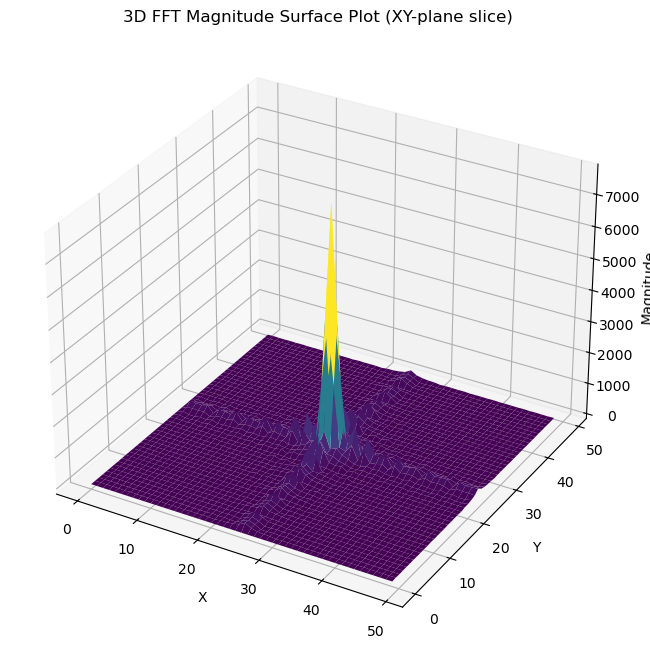

Simulating Data Collection for 4e-05
7853 100
(3, 785300)


In [ ]:
echo_times = [4e-5,4e-3]
images = []

for echo_time in echo_times:
    image,pixels_x,pixels_y,pixels_z = create_image(echo_time,fov_x,fov_y,fov_z,t1_myelin, t1_wm, t2_myelin, t2_wm, t2_star_myelin, t2_star_wm, inv_time)
    print("Simulating Data Collection for",echo_time)
    reconstructed_image = sample(image,pixels_x,pixels_y,res_mm)
    images.append(np.abs(reconstructed_image))
    

In [16]:
images = np.array(images)
#print(images)
#print(images[0].shape)
echo_times = np.array(echo_times)

In [17]:
# Create a container to hold the pixel values over time for each pixel (y, x, z)
pixels_over_time = np.empty((pixels_z, pixels_y, pixels_x), dtype=object)
num_echo_times = len(echo_times)

# Initialize the list for each pixel (y, x, z)
for z in range(pixels_z):
    for row in range(pixels_y):
        for col in range(pixels_x):
            pixels_over_time[z, row, col] = []

# Populate the pixels_over_time array with values from images_3d
# Assuming 'images' is a 4D array: (num_slices, pixels_y, pixels_x, num_echo_times)
for image_index in range(num_echo_times):
    for z in range(pixels_z):
        for row in range(pixels_y):
            for col in range(pixels_x):
                pixels_over_time[z, row, col].append(images[image_index][z][row][col])
            
print(pixels_over_time[0][0][0])        


[np.float64(2645.417405044618), np.float64(700.3537229746674)]


In [18]:
def fit_points(p,echo_times):
    p1 = p[0]
    p2 = p[1]
    x = p1/p2
    t2_star = (echo_times[1]-echo_times[0])/np.log(x)
    if t2_star < 0:
        t2_star = 0
    return t2_star


In [19]:
pixel_t2_lin = np.zeros((pixels_z,pixels_y,pixels_x))
for z in range (pixels_z):
    for row in range (pixels_y):
        for col in range (pixels_x):
            pixel_t2_lin[z][row][col] = fit_points(pixels_over_time[z][row][col],echo_times)

#print(pixel_t2_lin)   

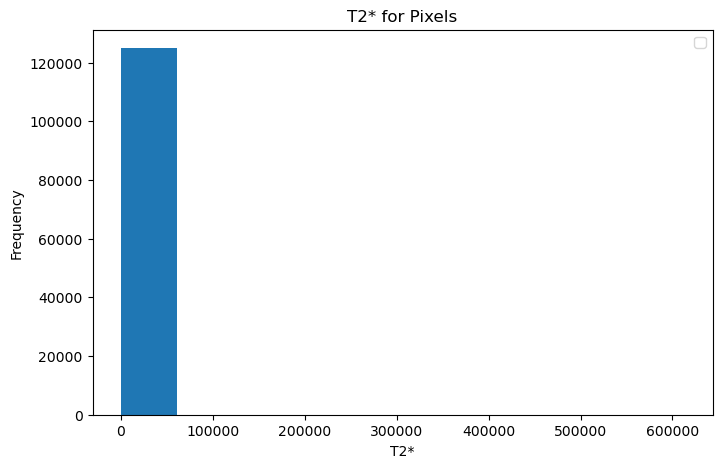

612891.2687163824


In [20]:
# Plot Echo Times vs Signal for the example pixel
pixel_t2_lin_flat = pixel_t2_lin.flatten()
plt.figure(figsize=(8, 5))
plt.hist(pixel_t2_lin_flat)  # Convert TE back to ms for display
plt.ylabel("Frequency")
plt.xlabel("T2*")
plt.title(f"T2* for Pixels")
plt.legend()
plt.show()
print(np.max(pixel_t2_lin))

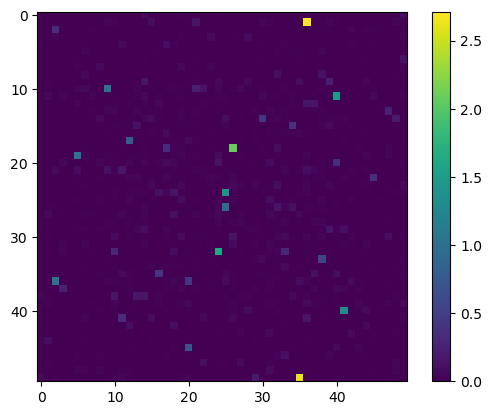

In [21]:
slice_idx = image.shape[0] // 2
slice_im_lin= pixel_t2_lin[slice_idx, :, :]
plt.imshow(slice_im_lin)
plt.colorbar()

23 27


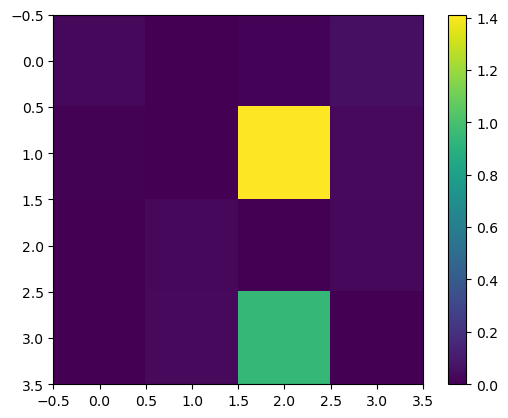

In [22]:
region = 2
lower = int((0.5*pixels_x)-region)
upper = int((0.5*pixels_x)+region)
print(lower,upper)
middle_square_lin = slice_im_lin[lower:upper,lower:upper]
plt.imshow(middle_square_lin)
plt.colorbar()

In [ ]:
def fit_curve(pixel_points,echo_times):
    # Define the T2* decay function
    def t2_star_decay(te, s0, t2_star):
        """
        T2* decay model: S(TE) = S0 * exp(-TE / T2*)
        """
        return s0 * np.exp(-te / t2_star)
    
    signal_values = pixel_points
    
    # Fit the data to the T2* decay model
    initial_guess = [max(signal_values), 0.03]  # Initial guess for [S0, T2*] 
    params, covariance = curve_fit(
    t2_star_decay,
    echo_times,
    signal_values,
    p0=initial_guess,
    bounds=([0, 0], [np.inf, np.inf])  # S0 > 0, T2* > 0
)
    
    # Extract the fitted parameters
    s0_fitted, t2_star_fitted = params
    
    # Generate the fitted signal curve
    fitted_signal = t2_star_decay(echo_times, s0_fitted, t2_star_fitted)
    
    # # Plot the data and the fitted curve
    # plt.figure(figsize=(8, 6))
    # plt.scatter(echo_times * 1e3, signal_values, label='Data', color='red')  # Convert TE back to ms for display
    # plt.plot(echo_times * 1e3, fitted_signal, label=f'Fitted Curve (T2* = {t2_star_fitted*1e3:.2f} ms)', color='blue')
    # plt.xlabel('Echo Time (TE) [ms]')
    # plt.ylabel('Signal Intensity')
    # plt.title('Fitting Data to T2* Decay Curve')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    
    # # Output fitted T2* value
    # print(f"Fitted T2* value: {t2_star_fitted * 1e3:.2f} ms")
    return t2_star_fitted

In [ ]:
pixel_t2 = np.zeros((pixels_z,pixels_y,pixels_x))
for z in range (pixels_z):
    for row in range (pixels_y):
        for col in range (pixels_x):
            pixel_t2[z][row][col] = fit_curve(pixels_over_time[z][row][col],echo_times)

#print(pixel_t2)        

In [ ]:
# Plot Echo Times vs Signal for the example pixel
pixel_t2_flat = pixel_t2.flatten()
plt.figure(figsize=(8, 5))
plt.hist(pixel_t2_flat)  # Convert TE back to ms for display
plt.ylabel("Frequency")
plt.xlabel("T2*")
plt.title(f"T2* for Pixels")
plt.legend()
plt.show()
print(np.max(pixel_t2))

In [ ]:
slice_idx = image.shape[0] // 2
slice_im= pixel_t2[slice_idx, :, :]
plt.imshow(slice_im)
plt.colorbar()

In [ ]:
region = 20
lower = int((0.5*pixels_x)-region)
upper = int((0.5*pixels_x)+region)
print(lower,upper)
middle_square = slice_im[lower:upper,lower:upper]
plt.imshow(middle_square)
plt.colorbar()